# Session 3
My homework can be found at the bottom of the notebook (under the header 'Homework').

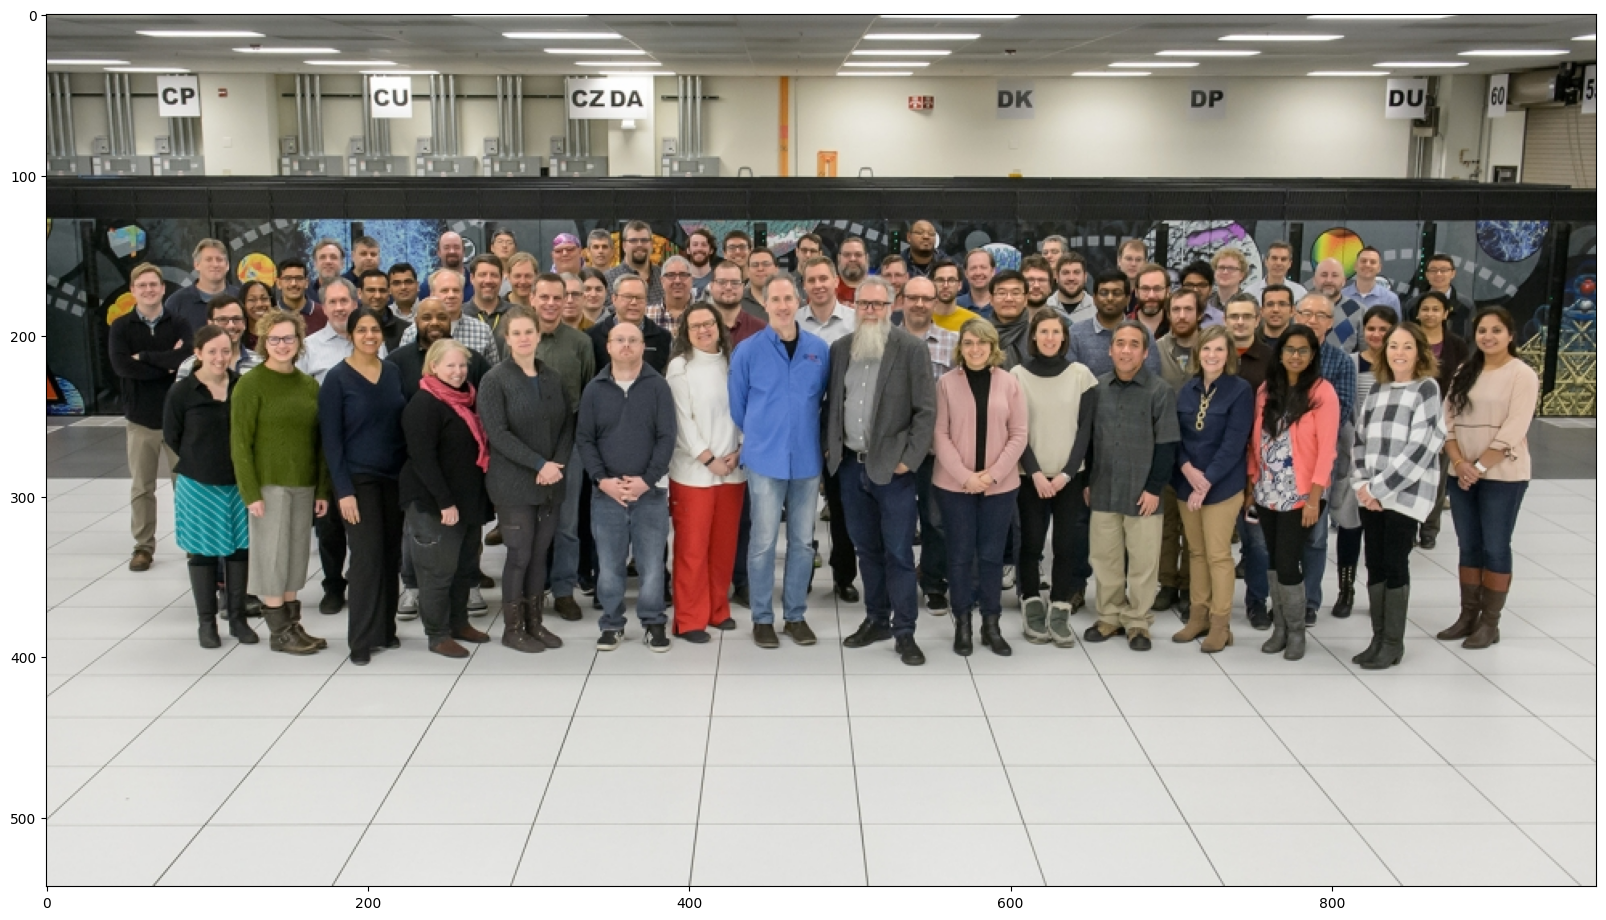

In [1]:
import torch, torchvision
from PIL import Image
alcf_image = Image.open("ALCF-Staff.jpg")
from matplotlib import pyplot as plt
figure = plt.figure(figsize=(20,20))
plt.imshow(alcf_image)
plt.show()

torch.Size([1, 3, 529, 951])
torch.Size([1, 3, 543, 965])


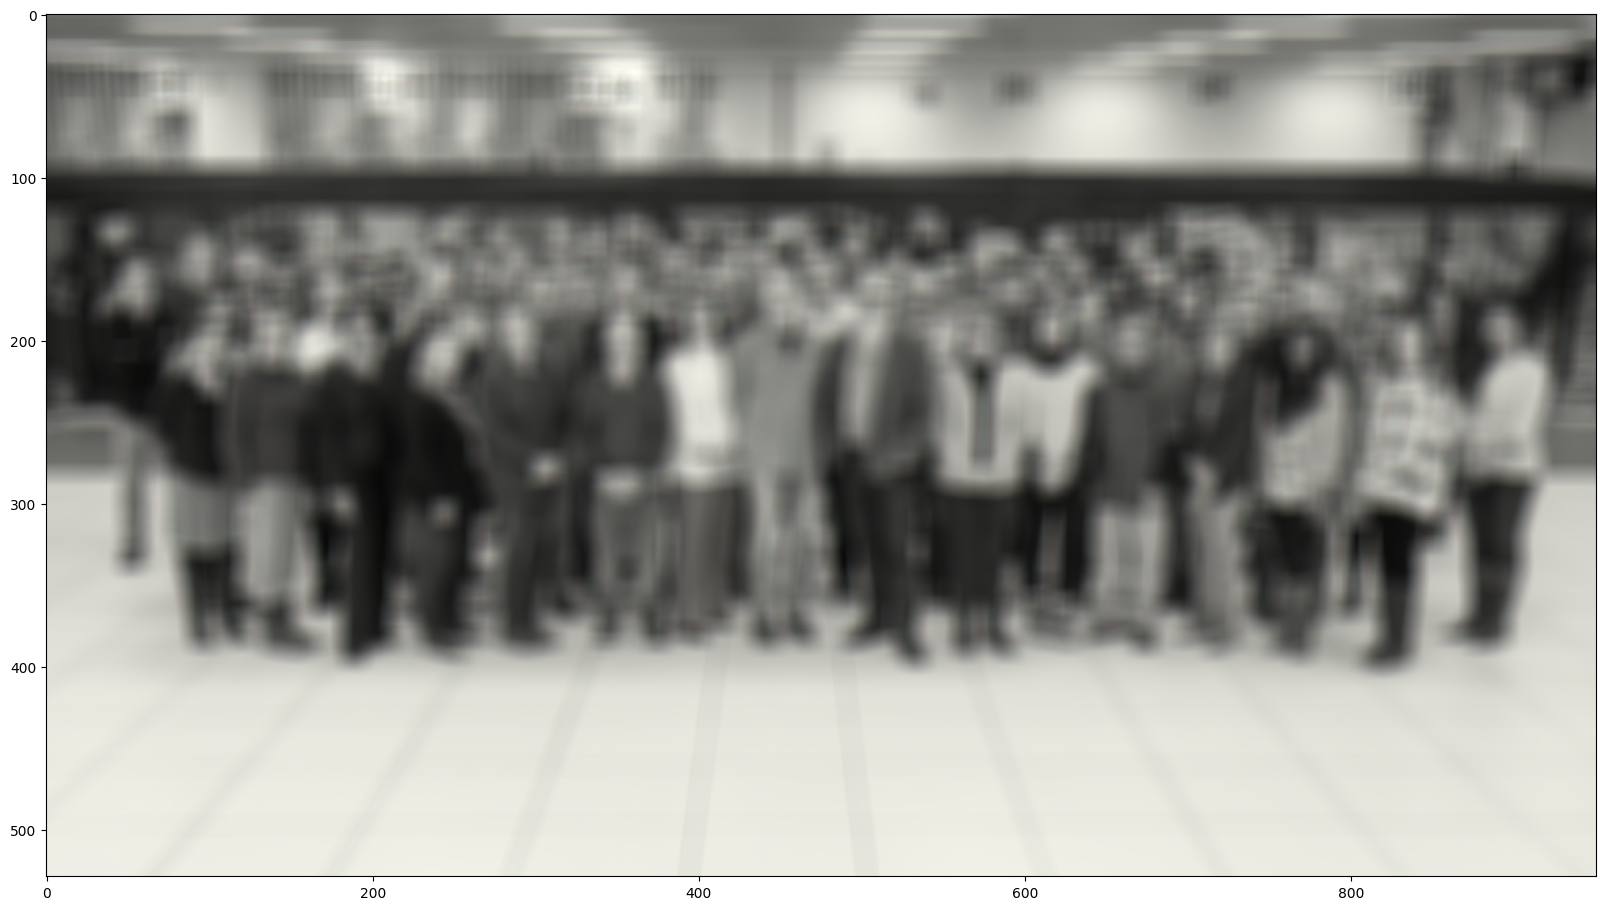

In [2]:
# Let's apply a convolution to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)

# Create a random convolution:
# shape is: (channels_in, channels_out, kernel_x, kernel_y)
conv_random = torch.rand((3,3,15,15))

alcf_rand = torch.nn.functional.conv2d(alcf_tensor, conv_random)
alcf_rand = (1./alcf_rand.max()) * alcf_rand
print(alcf_rand.shape)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)

torch.Size([1, 3, 543, 965])


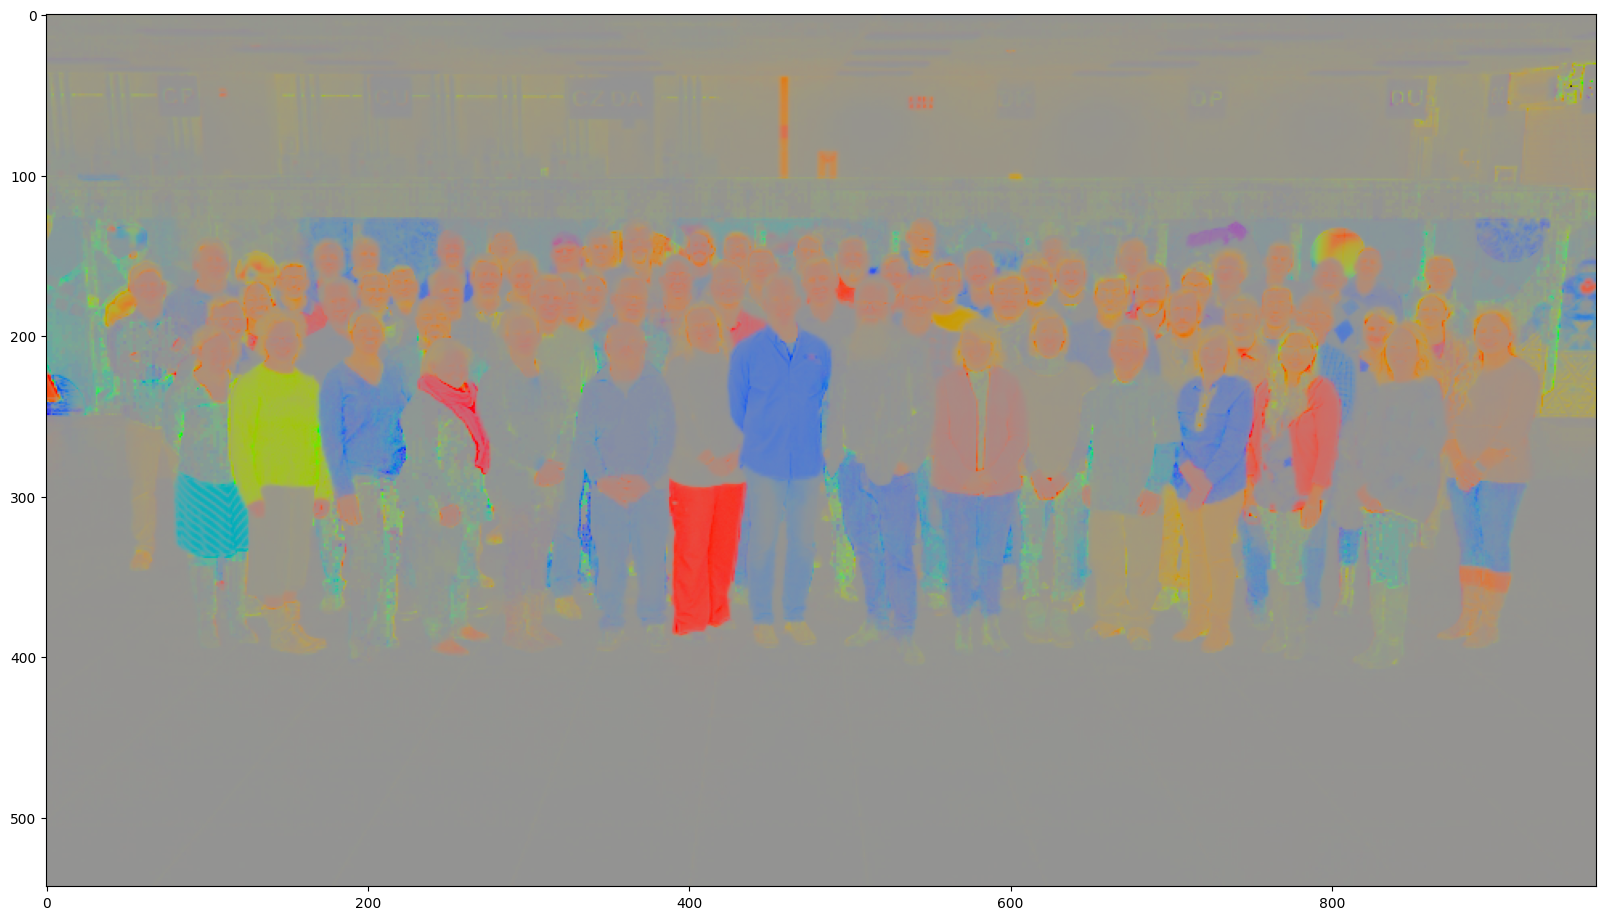

In [3]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)


alcf_rand = torch.nn.functional.normalize(alcf_tensor)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)

torch.Size([1, 3, 543, 965])
torch.Size([3, 271, 482])


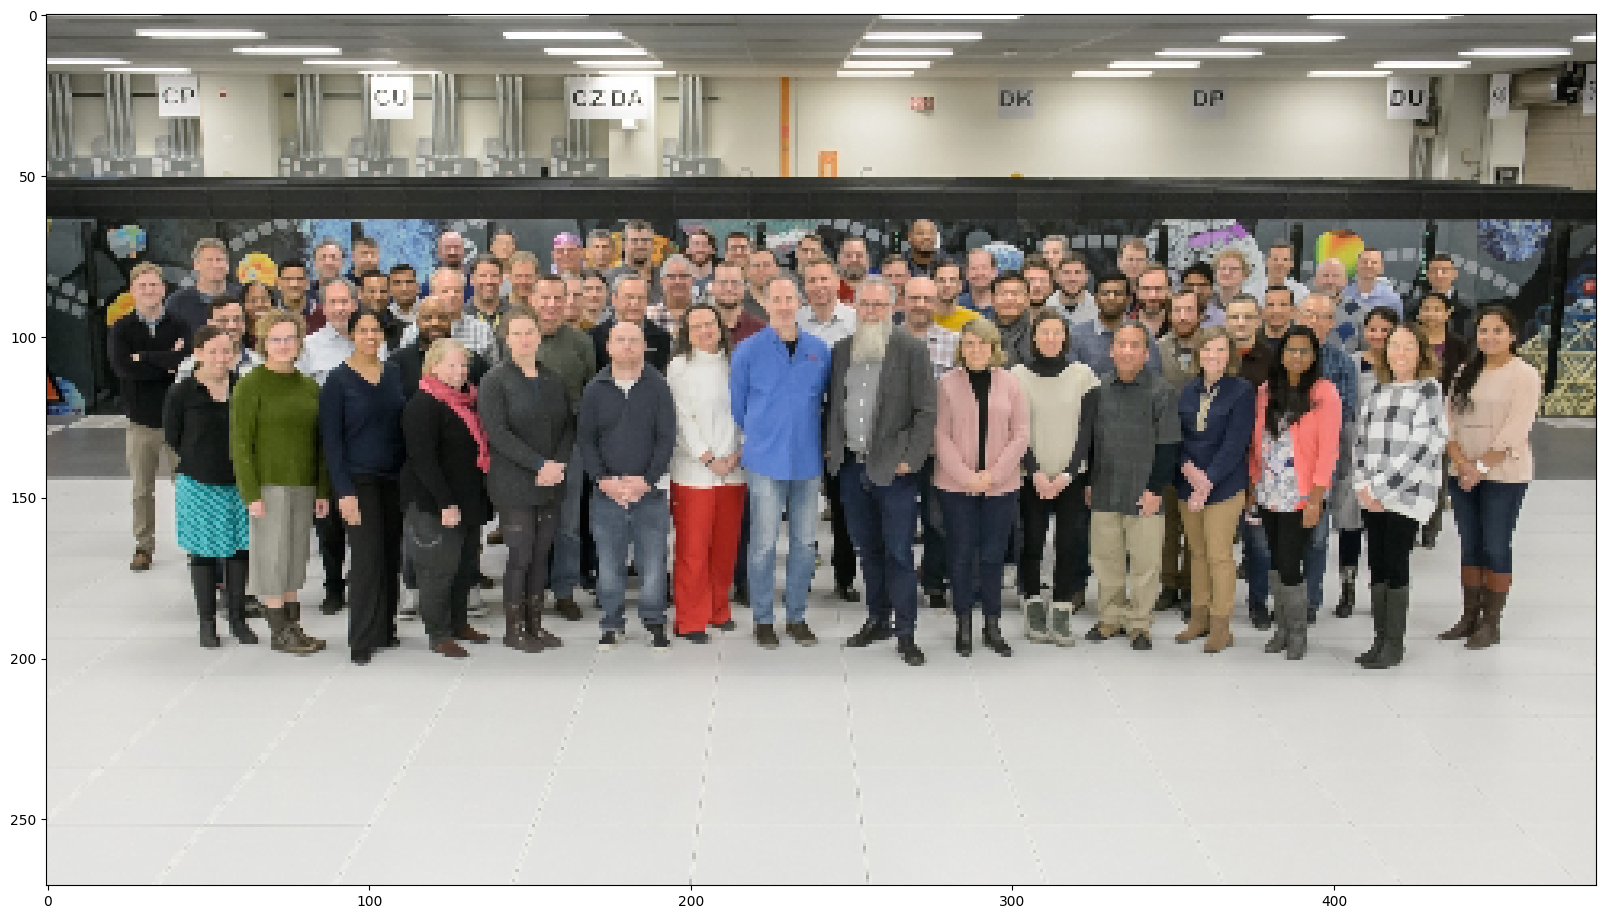

In [4]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)


alcf_rand = torch.nn.functional.max_pool2d(alcf_tensor, 2)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)
print(alcf_rand.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)

# Building a ConvNet

In [5]:
from torchvision.transforms import v2
training_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=True,
    download=False,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=False,
    download=False,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=True, 
    num_workers=4)
val_dataloader = torch.utils.data.DataLoader(validation_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=4)

/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

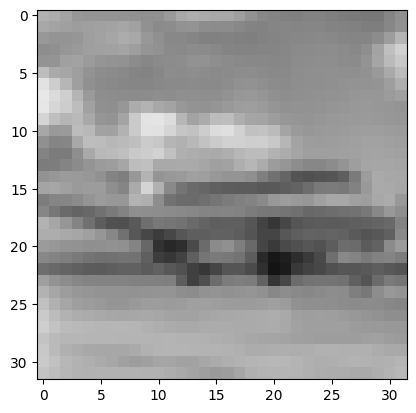

In [7]:
batch, (X, Y) = next(enumerate(train_dataloader))
plt.imshow(X[0].cpu().permute((1,2,0))); plt.show()

In [8]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

In [10]:
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )
    
    def forward(self, inputs):


        return self.downsample(self.norm(inputs))
        
        

class ConvNextBlock(nn.Module):


    def __init__(self, in_channels, shape, dropout_prob):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)
        
        self.dropout = nn.Dropout(p=dropout_prob)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)
        
        x = self.dropout(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs
    

class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage, dropout_prob):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)
        
        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape, dropout_prob=dropout_prob))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]
            


        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [11]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()
            
    loss /= num_batches
    correct /= (size*batch_size)
    
    accuracy = 100*correct
    return accuracy, loss

In [12]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()      

        progress_bar.update()

In [23]:
model = Classifier(32, 4, 3, 0.2)

model.cuda()

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 32, 32, 32]         128
├─LayerNorm: 1-2                         [128, 32, 32, 32]         65,536
├─Sequential: 1-3                        [128, 256, 4, 4]          --
│    └─ConvNextBlock: 2-1                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-2               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-3                  [128, 128, 32, 32]        4,224
│    │    └─Dropout: 3-4                 [128, 128, 32, 32]        --
│    │    └─Conv2d: 3-5                  [128, 32, 32, 32]         4,128
│    └─ConvNextBlock: 2-2                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-6                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-7               [128, 32, 32, 32]      

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Homework

I am changing the following hyperparameters:
- Increase the number of convolutions between downsampling from 2 to 3. The idea is, that more convolutions allow the model to construct more and more complex objects from the simpler ones detected in previous convolutions.
- Reduce the number of (initial) filters from 64 to 32. 64 filters seems to be already quite high to me. Instead of trying to identify many different shapes/objects in the original image, I want the model to detect fewer but simple shapes in the original image, and then build up more complex objects out of these through the additional convolution before downsampling.
- Add dropouts between the second and third convolution in each convolution block. The second convolution drastically increases the number of channels by a factor of 4. This may generate a lot of artifacts, so adding dropouts as a means of regularization may mitigate overfitting.

I have made these changes in the code above, and construct, train, and validate the model below.

In [25]:
from tqdm.notebook import tqdm
import numpy as np

epochs = 30

training_acc = np.empty(epochs)
training_acc[:] = np.nan
training_loss = np.empty(epochs)
training_loss[:] = np.nan
validation_acc = np.empty(epochs)
validation_acc[:] = np.nan
validation_loss = np.empty(epochs)
validation_loss[:] = np.nan

for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)
    
    # checking on the training loss and accuracy once per epoch
        
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
        training_acc[j] = acc
        training_loss[j] = loss
        
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
        validation_acc[j] = acc_val
        validation_loss[j] = loss_val

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.559, accuracy: 44.017


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.548, accuracy: 44.521


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 1.318, accuracy: 52.828


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.333, accuracy: 51.058


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 1.247, accuracy: 56.210


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.293, accuracy: 54.163


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 1.035, accuracy: 63.553


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.119, accuracy: 60.225


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 0.854, accuracy: 70.138


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 0.977, accuracy: 65.645


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 0.735, accuracy: 74.376


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 0.904, accuracy: 68.206


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 0.715, accuracy: 75.202


Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 0.923, accuracy: 68.552


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 0.683, accuracy: 76.388


Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.938, accuracy: 68.562


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 0.532, accuracy: 81.535


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.834, accuracy: 72.656


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 0.512, accuracy: 82.453


Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.863, accuracy: 72.172


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 0.430, accuracy: 85.139


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 0.796, accuracy: 74.199


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: training loss: 0.408, accuracy: 86.095


Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 0.839, accuracy: 74.090


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: training loss: 0.352, accuracy: 87.842


Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.817, accuracy: 75.030


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: training loss: 0.359, accuracy: 87.488


Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.884, accuracy: 74.417


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: training loss: 0.284, accuracy: 90.088


Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.807, accuracy: 75.405


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 0.306, accuracy: 89.322


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.869, accuracy: 75.138


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: training loss: 0.241, accuracy: 91.499


Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.806, accuracy: 76.483


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: training loss: 0.223, accuracy: 92.225


Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.860, accuracy: 77.027


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: training loss: 0.214, accuracy: 92.422


Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.855, accuracy: 76.998


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: training loss: 0.223, accuracy: 92.220


Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.872, accuracy: 76.780


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 0.207, accuracy: 92.674


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 0.897, accuracy: 76.543


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21: training loss: 0.189, accuracy: 93.298


Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 0.890, accuracy: 77.403


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22: training loss: 0.169, accuracy: 94.197


Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 0.860, accuracy: 77.571


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23: training loss: 0.197, accuracy: 93.163


Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 0.954, accuracy: 76.286


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24: training loss: 0.189, accuracy: 93.635


Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 0.934, accuracy: 77.482


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 0.154, accuracy: 94.409


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 0.895, accuracy: 77.898


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26: training loss: 0.162, accuracy: 94.274


Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 0.929, accuracy: 77.868


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27: training loss: 0.179, accuracy: 93.790


Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 0.995, accuracy: 77.354


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28: training loss: 0.163, accuracy: 94.302


Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 0.958, accuracy: 77.720


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29: training loss: 0.146, accuracy: 94.966


Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 0.964, accuracy: 77.848


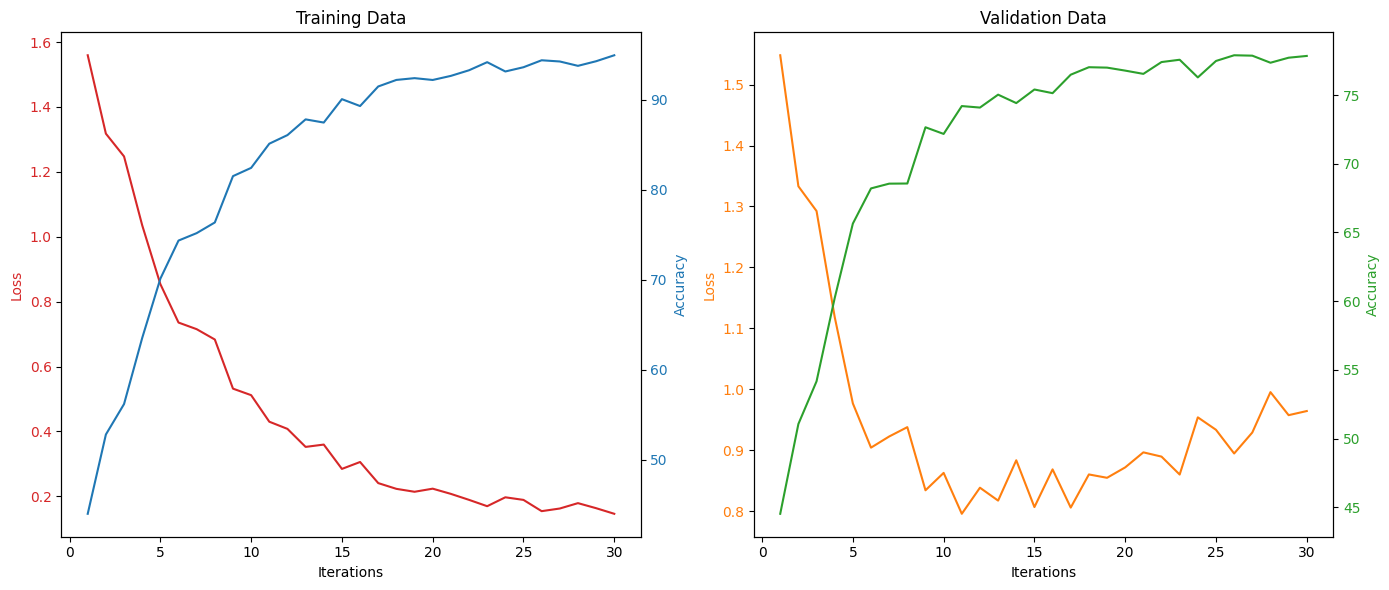

In [26]:
# Visualize results
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
iterations = range(1, epochs + 1)

# Plot training loss
color = 'tab:red'
axs[0].title.set_text('Training Data')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Loss', color=color)
axs[0].plot(iterations, training_loss, color=color, label='Training Loss')
axs[0].tick_params(axis='y', labelcolor=color)

# Create a twin Axes for training accuracy
axs[0].tick_params(axis='y', labelcolor=color)
axs_0_secondary = axs[0].twinx()  
color = 'tab:blue'
axs_0_secondary.set_ylabel('Accuracy', color=color)
axs_0_secondary.plot(iterations, training_acc, color=color, label='Training Accuracy')
axs_0_secondary.tick_params(axis='y', labelcolor=color)

# Plot validation loss
color = 'tab:orange'
axs[1].title.set_text('Validation Data')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Loss', color=color)
axs[1].plot(iterations, validation_loss, color=color, label='Validation Loss')
axs[1].tick_params(axis='y', labelcolor=color)

# Create a twin Axes for validation accuracy
axs[1].tick_params(axis='y', labelcolor=color)
axs_1_secondary = axs[1].twinx()  
color = 'tab:green'
axs_1_secondary.set_ylabel('Accuracy', color=color)
axs_1_secondary.plot(iterations, validation_acc, color=color, label='Validation Accuracy')
axs_1_secondary.tick_params(axis='y', labelcolor=color)

# Adjust layout
fig.tight_layout()

# Show plot
plt.show()

Compared to the model in the given jupyter notebook (validation loss of 1.024, validation accuracy of 75.930 after 15 epochs), the modified model has a marginally lower accuracy, but a lower loss (i.e., higher confidence in its predictions) after 15 epochs.